# Transfer Learning with TensorFlow Part 2 : Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it is time to learn about a new kind of transfer learning fine-tuning

## Creating helper functions
In previous notebooks, we have created a bunch of helper functions, now we could rewrite them all, however this is tedious.

Therefore, it is a good idea to put functions you will want to use again in a script you can download and import int your notebooks or elsewhere.

We've done this for some of the functions we've used previosuly here:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-05 06:40:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-05 06:40:53 (62.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import helper functions we are going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves,unzip_data,walk_through_dir

**NOTE :** If you are running this notebook in Google Colab, when it times out Colab will delete "helper_functions.py" so you will have to download it if you want to access your helper functions

## Let's get some Data

This time we are going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

Link : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-09-05 06:41:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   153MB/s    in 1.0s    

2023-09-05 06:41:01 (153 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data("/content/10_food_classes_10_percent.zip")

In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/

In [6]:
# Create training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train"
test_dir="/content/10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE
                                                                 )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE
                                                                 )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# see an example of a batch of data
for images, labels in train_data.take(1): # take one batch
  print(images,labels)

tf.Tensor(
[[[[2.46918365e+02 2.32918365e+02 2.45918365e+02]
   [2.44852036e+02 2.32852036e+02 2.44852036e+02]
   [2.40709183e+02 2.30352036e+02 2.44137756e+02]
   ...
   [1.88623238e+01 1.04235640e+01 4.71441650e+00]
   [2.13570900e+01 1.43570910e+01 8.35709095e+00]
   [1.79694824e+01 1.09694824e+01 4.96948242e+00]]

  [[2.46239792e+02 2.32239792e+02 2.45239792e+02]
   [2.46448990e+02 2.34448990e+02 2.46448990e+02]
   [2.46704086e+02 2.36346939e+02 2.50132660e+02]
   ...
   [1.95561676e+01 8.69902420e+00 2.62759590e+00]
   [2.66428318e+01 1.79183655e+01 1.07805986e+01]
   [2.03621140e+01 1.33621140e+01 7.36211395e+00]]

  [[2.46352036e+02 2.32352036e+02 2.45352036e+02]
   [2.41943878e+02 2.29943878e+02 2.41943878e+02]
   [2.40831635e+02 2.30474487e+02 2.44260208e+02]
   ...
   [2.27346630e+01 9.73466301e+00 2.96939087e+00]
   [2.50714798e+01 1.38011017e+01 7.30108786e+00]
   [2.85101147e+01 1.92958298e+01 1.18672571e+01]]

  ...

  [[1.06071556e+02 9.87143478e+01 1.19500084e+02]
   [1

In [11]:
# New version usage
## base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)


## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The squential API is straightforward it runs our layers in sequential order whereas the functional API
gives us more flexibility with our models

In [12]:
## 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Create the base model (so the underlying pre-trained patterns are not updated during training)
base_model.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="Input layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model : {x.shape  }")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# Compile the model
model_0.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit the model
hist_0 =model_0.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.25 * len(test_data)),
                    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                          experiment_name="10_percent_feature_extraction")]
                    )

16705208/16705208 [==============================] - 0s 0us/step


Shape after passing inputs through base model : (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230905-064110
Epoch 1/5
24/24 [==============================] - 89s 3s/step - loss: 1.8678 - accuracy: 0.4307 - val_loss: 1.3106 - val_accuracy: 0.7319
Epoch 2/5
24/24 [==============================] - 81s 3s/step - loss: 1.0952 - accuracy: 0.7613 - val_loss: 0.8561 - val_accuracy: 0.8405
Epoch 3/5
24/24 [==============================] - 78s 3s/step - loss: 0.7833 - accuracy: 0.8320 - val_loss: 0.7072 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 78s 3s/step - loss: 0.6367 - accuracy: 0.8467 - val_loss: 0.5863 - val_accuracy: 0.8684
Epoch 5/5
24/24 [==============================] - 78s 3s/step - loss: 0.5437 - accuracy: 0.8680 - val_loss: 0.5648 - val_accuracy: 0.8635


In [13]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 130s 2s/step - loss: 0.5588 - accuracy: 0.8628


[0.5587580800056458, 0.8628000020980835]

In [14]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [15]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
# How about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


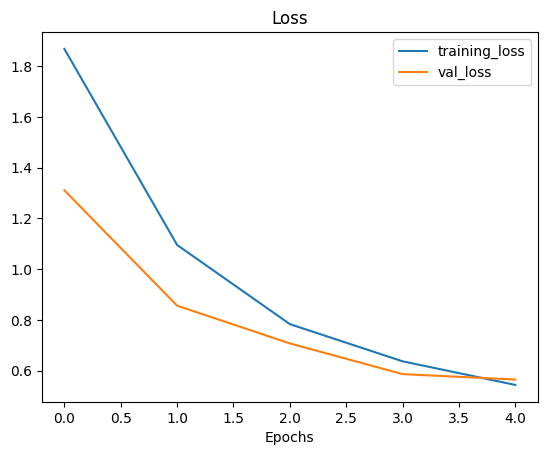

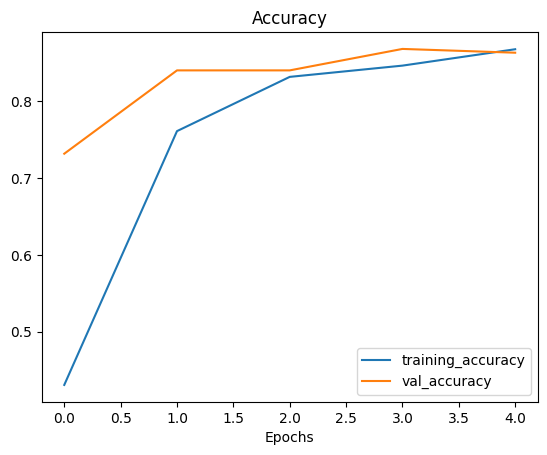

In [17]:
# Check out our model's training curves
plot_loss_curves(hist_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Avreage Pooling 2D Layer...

We have a tensor after our model goes through 'base_model' of shape (None,7,7,1280)

But then when it passes through GlobalAvearegPooling2D, it turns into (None,1280)

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAvearegPooling2D.

In [18]:
# Define the input shape
input_shape=(1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor : \n {input_tensor}")

# Pass the random tensor through a global avreage pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor : \n {global_average_pooled_tensor} +\n")

# Check the shape of the different tensors
print(f"Shape of the input tensor : {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor : {global_average_pooled_tensor.shape}")

Random input tensor : 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]
2D global average pooled random tensor : 
 [[-0.09368646 -0.45840445 -0.28855976]] +

Shape of the input tensor : (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor : (1, 3)


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>


Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (tf.keras.layers.Dense()), it also condenses the information found by the base model into a lower dimension feature vector.

🔑 Note: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.

## Running a series of transfer learning experiments

We have seen the incredible results transfer learning can get with only 10% of the training data, however, how does it go with 1% of the training data... how about we set up a bunch of experiments to find out :

1. 'model_1' - use feature extraction transfer llearning with 1% of the training data with data augmentation

2. 'model_2' - use feature extraction transfer learning with 10% of the training data with data augmentation

3. 'model_3' - use fine-tuning transfer learning on 10% of the training data with data augmentation

4. 'model_4' - use fine-tuning transfer learning on 100% of the training data with data augmentation

**NOTE :** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [20]:
# Download an unzip the data - preprocessed from food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")


--2023-09-05 06:50:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 142.251.163.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   191MB/s    in 0.7s    

2023-09-05 06:50:21 (191 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
# Create training and test dirs
train_dir = "/content/10_food_classes_1_percent/train"
test_dir="/content/10_food_classes_1_percent/test"

In [22]:
# How many images we have
walk_through_dir("/content/10_food_classes_1_percent")

There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/grille

In [23]:
# Setup data loaders
IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=32

                                                                )

test_data =  tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=32

                                                                )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentatin right into the model as a layer
To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

Off the top our of head, after reading the docs, the benefits of using data augmentation inside the model are :

* Preprocessing of images (augmenting them) happens on the GPU instead of CPU (like ImageGenerator)

* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage
data_augmented = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) # keep for models like Resnet50V2 but efficientNet already have rescaling built-in

], name="data_augmentation"
    )

In [ ]:
## augmented_img = data_augmentation(img, training=True)

### Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 510.5, 345.5, -0.5)

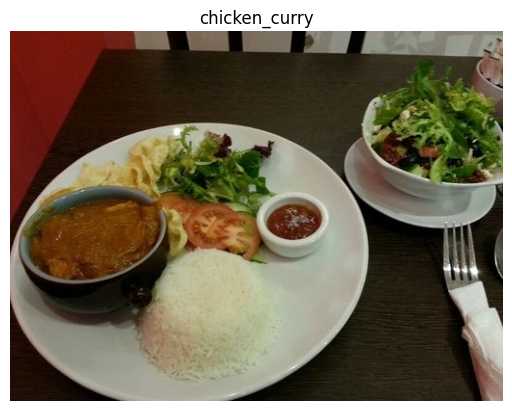

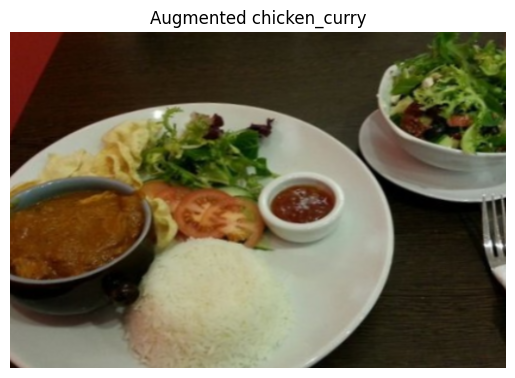

In [42]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data.class_names)
target_dir = "/content/10_food_classes_1_percent/train/"+target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(target_class)
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmented(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title("Augmented "+target_class)
plt.axis(False)


## Model 1 : Feature extraction transfer learning on 1% of the data with data augmentation



In [45]:
# Set up input shape and base model, freezing the base model layers
input_shape = (224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape,
                               name="Input_layer"
                               )

# Add in data augmentation Sequential model as a layer
x = data_augmented(inputs)

# Give base_model the inputs (after augmentation) and do not train it
x = base_model(x,training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

#Fit the model
hist_1 = model_1.fit(train_data,
                     epochs=5,
                     steps_per_epoch=len(train_data),
                     validation_data=test_data,
                     validation_steps=int(0.25 * len(test_data)),
                     #Track model training loss
                     callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                            experiment_name="1_percent_data_aug")]
                     )


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230905-080824
Epoch 1/5
3/3 [==============================] - 37s 14s/step - loss: 2.4134 - accuracy: 0.1143 - val_loss: 2.1421 - val_accuracy: 0.2385
Epoch 2/5
3/3 [==============================] - 45s 21s/step - loss: 2.0938 - accuracy: 0.2429 - val_loss: 2.0082 - val_accuracy: 0.3174
Epoch 3/5
3/3 [==============================] - 45s 21s/step - loss: 1.8746 - accuracy: 0.4429 - val_loss: 1.9148 - val_accuracy: 0.3816
Epoch 4/5
3/3 [==============================] - 44s 21s/step - loss: 1.7401 - accuracy: 0.4571 - val_loss: 1.8104 - val_accuracy: 0.4523
Epoch 5/5
3/3 [==============================] - 44s 21s/step - loss: 1.6074 - accuracy: 0.6571 - val_loss: 1.7407 - val_accuracy: 0.4803


In [46]:
# Check out the model summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [47]:
# Evalaute on full dataset
model_1.evaluate(test_data)

79/79 [==============================] - 106s 1s/step - loss: 1.7522 - accuracy: 0.4828


[1.7522177696228027, 0.4828000068664551]

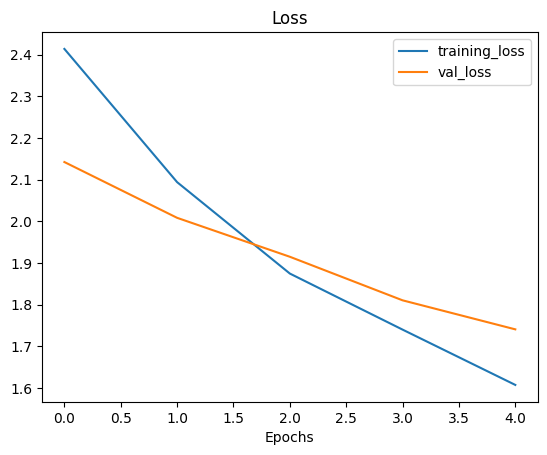

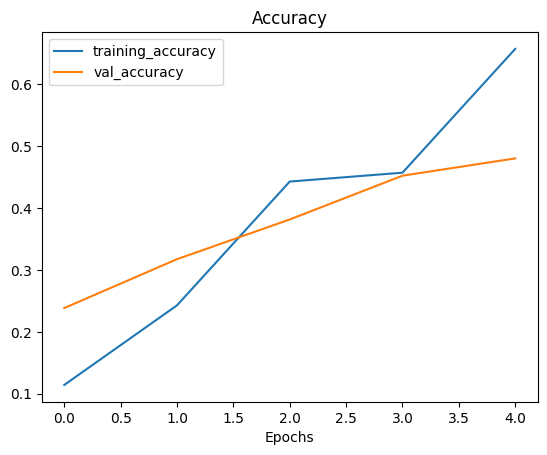

In [48]:
# How do the model with 1% of the and dataaugmentation loss curves look?
plot_loss_curves(hist_1)

In [109]:
## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

# we already have the data

train_dir="/content/10_food_classes_10_percent/train"
test_dir="/content/10_food_classes_10_percent/test"


In [110]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE=(224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=32
                                                                 )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=32
                                                                 )


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [111]:
# How many images we have
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/

In [112]:
# Create model 2 with data augmentation buit in
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmented = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # if you are using a model such as ResNet50V2, you'll need to rescale your data
],
  name="data_augmentation")

# Set up the iput shape to our model
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
bade_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape,name="input_layer")
x = data_augmented(inputs) # augment out training images (augmentation does not occur on test data)
x = base_model(x,training=False) # pass augmented images to base model but keep it in inference mode, this also ensures batchnorm layers do not get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)
model_2=tf.keras.Model(inputs,outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )


In [56]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback

The modelcheckpoint callback intermediately saves our model
(the full model or just the weights) during the training. This is useful so we can come and start where we left off.

In [117]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1
                                                         )

### Fit model 2 passing in the ModelCheckpoint callback

In [114]:
# fit the model saving checkpoints every epoch

initial_epoch=5

#Fit the model
hist_2 = model_2.fit(train_data,
                     epochs=initial_epoch,
                     steps_per_epoch=len(train_data),
                     validation_data=test_data,
                     validation_steps=int(0.25 * len(test_data)),
                     #Track model training loss
                     callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                            experiment_name="10_percent_data_aug"),
                                checkpoint_callback]
                     )


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230905-105615
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.8003 - accuracy: 0.3840
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 91s 4s/step - loss: 1.8003 - accuracy: 0.3840 - val_loss: 1.0727 - val_accuracy: 0.6891
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.9073 - accuracy: 0.7453
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 76s 3s/step - loss: 0.9073 - accuracy: 0.7453 - val_loss: 0.7082 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.8253
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 78s 3s/step - loss: 0.6513 - accuracy: 0.8253 - val_loss: 0.5744 - val_accuracy: 0.8224
Epoch 4/5
24/

In [62]:
# How were model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 122s 2s/step - loss: 0.5588 - accuracy: 0.8628


[0.5587580800056458, 0.8628000020980835]

In [61]:
# Check model_2 results on all test data
model_2.evaluate(test_data)

79/79 [==============================] - 116s 1s/step - loss: 0.5897 - accuracy: 0.8572


[0.5896686315536499, 0.857200026512146]

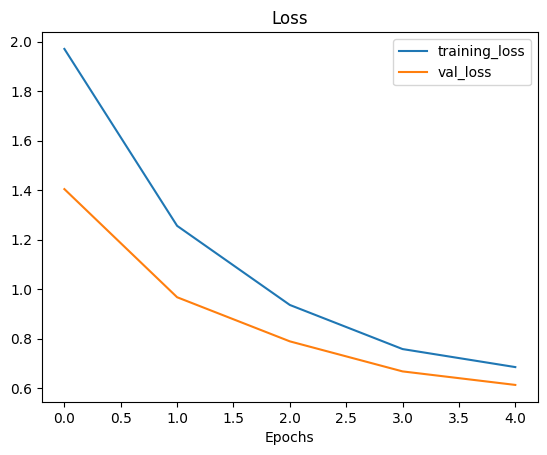

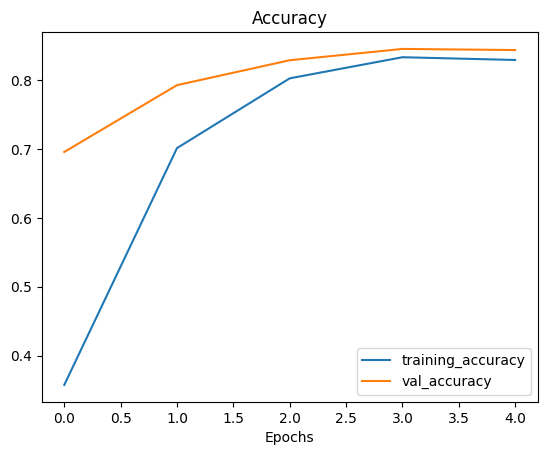

In [63]:
# Plot loss curves
plot_loss_curves(hist_2)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [118]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [65]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)
loaded_weights_model_results

79/79 [==============================] - 123s 2s/step - loss: 0.5897 - accuracy: 0.8572


[0.5896686315536499, 0.857200026512146]

In [66]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked
# There is a little bit difference because computer does not store floating points number exactly

## Model 3 : Fine-tuning an existing model on 10% of the data
**NOTE :** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data

In [119]:
# Layers in loaded model
model_2.layers

In [120]:
# Are these layers are trainable ?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7d14e5dc4700> True
<keras.engine.sequential.Sequential object at 0x7d14f1b58190> True
<keras.engine.functional.Functional object at 0x7d14e9194fd0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7d14f1dd1270> True
<keras.layers.core.dense.Dense object at 0x7d14f18bb790> True


In [121]:
# What layers are in our base_model (EfficientNetB0) and are they trainable ?#
for i,layer in enumerate( model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_6 False
2 normalization_3 False
3 rescaling_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [122]:
# How many trainable variables are in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [123]:
# To begin fine-tuning, let'S start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable=True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), # for fine-tuning rule you want to lower your learning_rate by 10x
                metrics=["accuracy"]
                )

**NOTE :**  When using fine-tuning it best practice to lower your learning rate by some amount. How much ? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values)

In [124]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name, layer.trainable)

0 input_4 False
1 rescaling_6 False
2 normalization_3 False
3 rescaling_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [125]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there
print(len(model_2.trainable_variables))

12


In [82]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epoch + 5

# Refit the model (same as model_2 except with more trainable layers)
hist_3 = model_2.fit(train_data,
                     epochs=fine_tune_epochs,
                     steps_per_epoch=len(train_data),
                     validation_data=test_data,
                     validation_steps=int(0.25 * len(test_data)),
                     initial_epoch = hist_2.epoch[-1], # start training from previouslast epoch
                     callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                            experiment_name="10_percent_fine-tune_last_10"),
                                checkpoint_callback]
                     )

Saving TensorBoard log files to: transfer_learning/10_percent_fine-tune_last_10/20230905-095810
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.8533
Epoch 5: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 78s 3s/step - loss: 0.5722 - accuracy: 0.8533 - val_loss: 0.4974 - val_accuracy: 0.8355
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.4369 - accuracy: 0.8760
Epoch 6: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 90s 4s/step - loss: 0.4369 - accuracy: 0.8760 - val_loss: 0.4748 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.8787
Epoch 7: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 77s 3s/step - loss: 0.3878 - accuracy: 0.8787 - val_loss: 0.4673 - val_accuracy: 0.8388
E

In [83]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)
results_fine_tune_10_percent

79/79 [==============================] - 114s 1s/step - loss: 0.4021 - accuracy: 0.8616


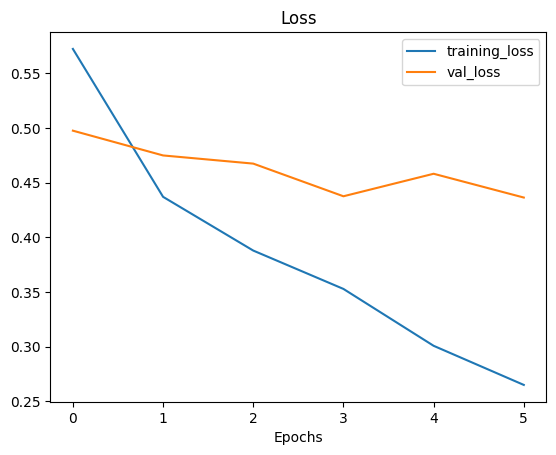

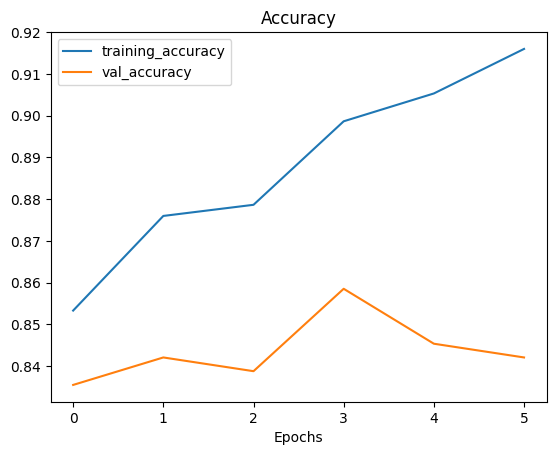

In [84]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(hist_3)

The plot_loss_curves function works great with models which have only been fit once, however, we want something to compare one series of running fit() with another (e.g before and after fine-tuning)



In [93]:
# Let's create a function to compare training histories

def compare_historys(original_history, new_history, initial_epoch):
  """
  Compares two tensorflow history objects.
  """
  # get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["accuracy"]
  total_val_loss = val_loss + new_history.history["loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training Accuracy")
  plt.plot(total_val_acc,label="Validation Accuracy")
  plt.plot([initial_epoch-1,initial_epoch-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Training Loss")
  plt.plot(total_val_loss,label="Validation Loss")
  plt.plot([initial_epoch-1,initial_epoch-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

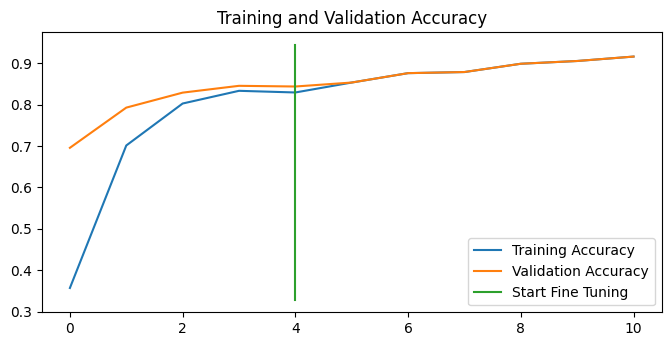

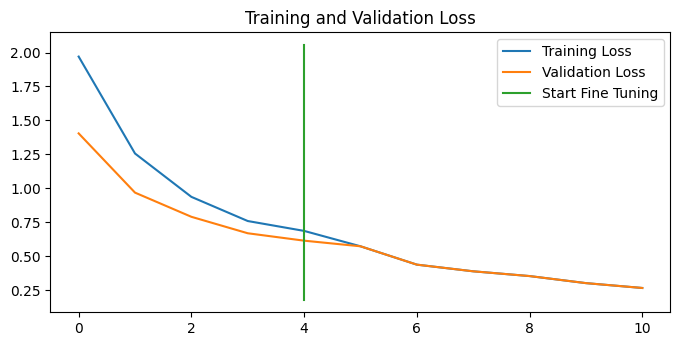

In [94]:
compare_historys(hist_2,hist_3,initial_epoch=5)

## Model 4: Fine-tuning and existing model on all of the data

In [95]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")


--2023-09-05 10:33:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.207, 142.251.16.207, 172.253.62.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   155MB/s    in 3.2s    

2023-09-05 10:33:14 (153 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [96]:
# Set up training and test dir
train_dir = "/content/10_food_classes_all_data/train"
test_dir="/content/10_food_classes_all_data/test"

In [97]:
# How many images are we working with now
walk_through_dir("/content/10_food_classes_all_data")

There are 2 directories and 0 images in '/content/10_food_classes_all_data'.
There are 10 directories and 0 images in '/content/10_food_classes_all_data/test'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/grilled_salmon'.


In [99]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 )

test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 )

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we have loaded in is the same as what we have been using for previous experiments (all experiments have used the same dataset).

Let's verify this...

In [100]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 125s 2s/step - loss: 0.4021 - accuracy: 0.8616


[0.4021151065826416, 0.8615999817848206]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [105]:
# Load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was  fine-tuned from
model_2.load_weights(checkpoint_path)

In [115]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 111s 1s/step - loss: 0.4979 - accuracy: 0.8460


[0.49789947271347046, 0.8460000157356262]

In [ ]:
# Check to see if our model_2 has been reverted back to feature extraction results

Alright, the previous steps seem quite confusing but all we have done is ⁉

1. Trained a feature extraction transfer learning model  for 5 epochs on 10 percent of the data with data augmentation (model_2) and we saved model's weights using ModelCheckpoint callback

2. Fine-tuned the same model on the same 10 percent data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).

3. Saved the results and training logs each time

4. Reloaded the model from step 1 to do the same steps as step 2 except this time we are going to use all of the data (model_4)

In [126]:
# Check which layers are tunble in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [131]:
# Let's drill into our base_model (efficientnetb0 ) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)


0 input_4 False
1 rescaling_6 False
2 normalization_3 False
3 rescaling_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [132]:
# Compile
# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), # for fine-tuning rule you want to lower your learning_rate by 10x
                metrics=["accuracy"]
                )


In [133]:
# Continue to train and fine-tune the model to our data (100% of the training data)
# Refit the model (same as model_2 except with more trainable layers and with all data)
hist_4 = model_2.fit(train_data,
                     epochs=fine_tune_epochs,
                     steps_per_epoch=len(train_data),
                     validation_data=test_data,
                     validation_steps=int(0.25 * len(test_data)),
                     initial_epoch = hist_2.epoch[-1], # start training from previouslast epoch
                     callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                            experiment_name="all_fine-tune_last_10"),
                                checkpoint_callback]
                     )

Saving TensorBoard log files to: transfer_learning/full_data_fine-tune_last_10/20230905-111810
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.8813
Epoch 5: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 87s 3s/step - loss: 0.4279 - accuracy: 0.8813 - val_loss: 0.4695 - val_accuracy: 0.8339
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.9053
Epoch 6: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 78s 3s/step - loss: 0.3293 - accuracy: 0.9053 - val_loss: 0.4455 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.9160
Epoch 7: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 80s 3s/step - loss: 0.2967 - accuracy: 0.9160 - val_loss: 0.4359 - val_accuracy: 0.8470
Ep

In [134]:
# Let's evaluate on all the data
result_all_data = model_2.evaluate(test_data)

79/79 [==============================] - 109s 1s/step - loss: 0.4369 - accuracy: 0.8540


In [135]:
result_all_data

[0.4368816316127777, 0.8539999723434448]

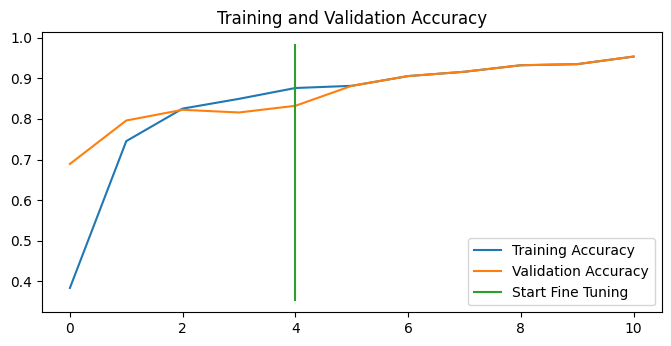

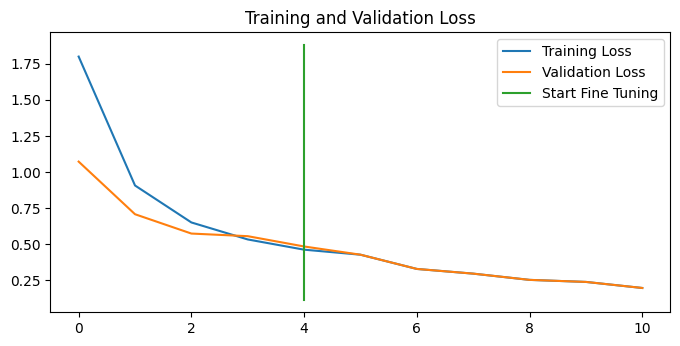

In [136]:
# How did fine-tuning gowith more data
compare_historys(hist_2,hist_4,initial_epoch=5)

## View our experiment data on TensorBoard


In [138]:
# View tensorboard logs of transfer learning modelling experiments (should -4 models)
# Upload Tensorboard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader once its finished uploading

2023-09-05 11:40:08.898126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   CSD-KQT-GQM



New experiment created. View your TensorBoard at: https://tensorboard.dev/

My Tensorboard experiments are available at : https://tensorboard.dev/experiment/xhkdobYvSLGLEqe0SD8zFQ/

In [139]:
# View all of your uploaded Tensorboard.dev experiments
!tensorboard dev list

2023-09-05 11:47:14.222184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/xhkdobYvSLGLEqe0SD8zFQ/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   xhkdobYvSLGLEqe0SD8zFQ
	Created              2023-09-05 11:40:41 (6 minutes ago)
	Updated              2023-09-05 11:40:48 (6 minutes ago)
	Runs                 13
	Tags                 5
	Scalars              192
	Tensor bytes         0
	Binary object bytes  6237223
https://tensorboard.dev/experiment/fLXv3VeEQKe4cwCKbvg3gA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   fLXv3VeEQKe4cwCKbvg3gA
	Created              2023-09-04 16:23:14 (19 hours ag

In [ ]:
# To delete an experiment
#!tensorboard dev delete --experiment_id (id)